In [1]:
import pandas as pd
import numpy as np
import os

In [29]:
data=pd.read_csv(os.path.join('../Dataset','Gowalla_cleanCheckins.csv'))# Load the dataset
data.head()

,user,check-in time,latitude,longitude,location id
0,0,2010-10-19T23:55:27Z,30.235909,-97.795140,22847
1,0,2010-10-18T22:17:43Z,30.269103,-97.749395,420315
2,0,2010-10-17T23:42:03Z,30.255731,-97.763386,316637
3,0,2010-10-17T19:26:05Z,30.263418,-97.757597,16516
4,0,2010-10-16T18:50:42Z,30.274292,-97.740523,5535878


In [ ]:
#num of users
data['user'].nunique() 

107092

In [36]:
def haversine_vec(lat1, lon1, lat2, lon2):
    R = 6371
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = phi2 - phi1
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

data['check-in time'] = pd.to_datetime(data['check-in time'], utc=True)
data.sort_values(by=['user', 'check-in time'], inplace=True)
data['time_diff']=data.groupby('user')['check-in time'].diff().fillna(pd.Timedelta('1 day'))
data['distance']=data.groupby('user').apply(lambda x: haversine_vec(x['latitude'], x['longitude'], x['latitude'].shift(), x['longitude'].shift())).reset_index(drop=True)
filtered_data = data[~((data['time_diff'] <= pd.Timedelta('1 day')) & (data['distance'] <= 3))]

C:\Users\USER\AppData\Local\Temp\ipykernel_15680\4136404726.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data['distance']=data.groupby('user').apply(lambda x: haversine_vec(x['latitude'], x['longitude'], x['latitude'].shift(), x['longitude'].shift())).reset_index(drop=True)


In [37]:
filtered_data = filtered_data.drop(columns=['time_diff', 'distance'])
filtered_data = filtered_data.sort_values(by=['user', 'check-in time'])
filtered_data = filtered_data.reset_index(drop=True)

In [ ]:
filtered_data['year']=filtered_data['check-in time'].dt.year
filtered_data['month']=filtered_data['check-in time'].dt.month
filtered_data['day']=filtered_data['check-in time'].dt.day
filtered_data['time_step']=filtered_data.groupby('user').cumcount() + 1

In [41]:
filtered_data.to_csv(os.path.join('../Dataset', 'Gowalla_cleanCheckins_filtered.csv'), index=False)  # Save the filtered data

In [ ]:
filtered_data=pd.read_csv(os.path.join('../Dataset','Gowalla_cleanCheckins_filtered.csv'))

In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

train_data=[]
test_data=[]
for user_id, user_df in filtered_data.groupby('user'):

    if len(user_df) < 5:
        continue
    train, test = train_test_split(user_df, test_size=0.2, random_state=42)

    train_data.append(train)
    test_data.append(test)

train_data = pd.concat(train_data,ignore_index=True)
test_data=pd.concat(test_data,ignore_index=True)

train_data.to_csv(os.path.join('Dataset','train_data.csv'),index=False)
test_data.to_csv(os.path.join('Dataset','test_data.csv'),index=False)

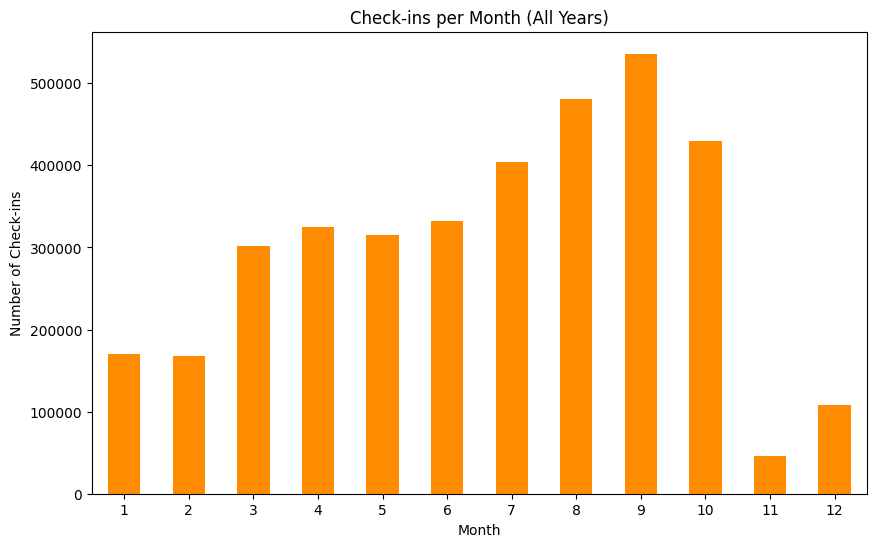

In [11]:
import pandas as pd
import matplotlib.pyplot as plt


monthly_counts = filtered_data.groupby("month")["user"].count().sort_index()

plt.figure(figsize=(10, 6))
monthly_counts.plot(kind="bar", color="darkorange")
plt.title("Check-ins per Month (All Years)")
plt.ylabel("Number of Check-ins")
plt.xlabel("Month")
plt.xticks(rotation=0)
plt.show()


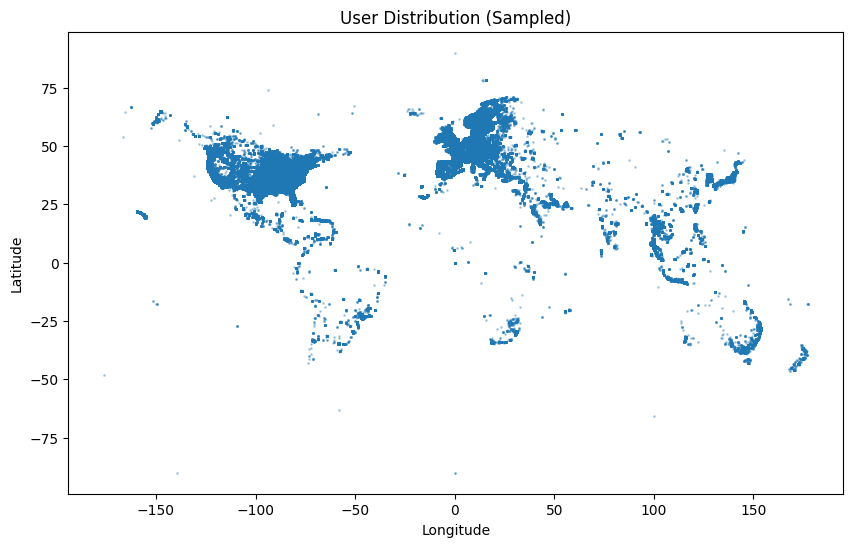

In [13]:
sampled = filtered_data

plt.figure(figsize=(10, 6))
plt.scatter(sampled["longitude"], sampled["latitude"], s=1, alpha=0.3)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("User Distribution (Sampled)")
plt.show()

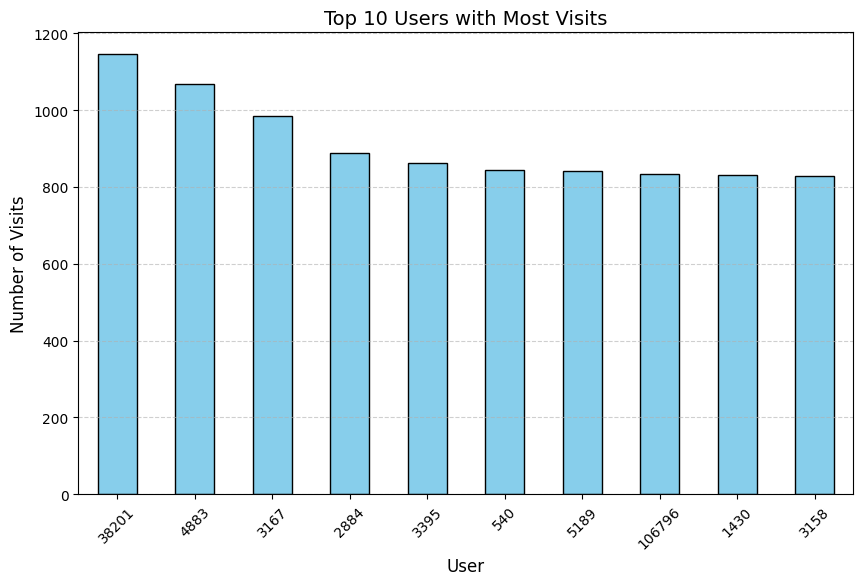

In [15]:
# Top 10 users with the most samples
top_users = filtered_data["user"].value_counts().head(10)

plt.figure(figsize=(10,6))
top_users.plot(kind="bar", color="skyblue", edgecolor="black")

plt.title("Top 10 Users with Most Visits", fontsize=14)
plt.xlabel("User", fontsize=12)
plt.ylabel("Number of Visits", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

df=filtered_data
kmeans = KMeans(n_clusters=10, random_state=42)
df['cluster'] = kmeans.fit_predict(df[['latitude','longitude']])  # if you also have longitude, add it here

centers = kmeans.cluster_centers_  # cluster centers
labels = df['cluster'].values      # cluster labels



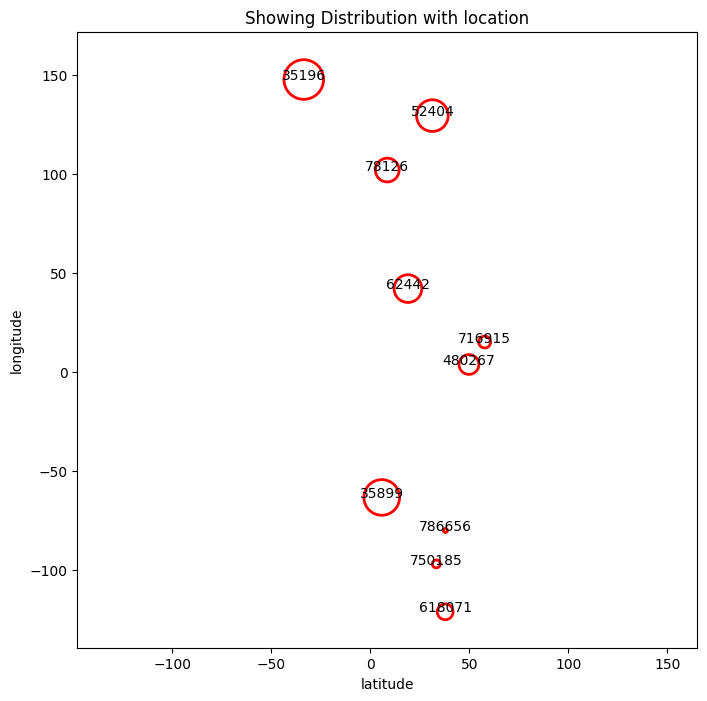

In [56]:
cluster_count=df['cluster'].value_counts().sort_values(ascending=False)

radius=[1*i for i in range(1,11)]
fig, ax = plt.subplots(figsize=(8, 8))

# plot data points (optional, just to visualize clusters)

# draw circles for each cluster center
for i, cluster_id in enumerate(cluster_count.index):
    circle = plt.Circle(centers[cluster_id], radius[i], 
                        color="red", fill=False, linewidth=2)
    ax.add_patch(circle)
    ax.text(centers[cluster_id][0], centers[cluster_id][1], 
            str(cluster_count.loc[cluster_id]),
            color="black", fontsize=10, ha="center")

plt.axis("equal")
plt.xlabel("latitude")
plt.ylabel("longitude")
plt.title("Showing Distribution with location")
plt.show()